In [1]:
# IMPORTS

from GridClass import *

In [10]:
# SET PARAMETERS

np.random.seed(13340)

# GRID INSTANCE INITIALIZATION PARAMETERS
FROM_FILE = True
CONTROL = True
EZW = 100
BZW = 10
ROWS = 10 # Random grid
COLS = 10 # Random grid

# SIMULATION PARAMETERS
# Control zone parameters
BZ_eff = 0

# Common parameters
A = 3 # 3 kp rate of population growth
B = 14.069
a = 0 # relative carrying capacity in non olive plants
tol = 1e-8 # 1e-8 numerical noise tolerance (IF TOLERANCE IS TOO BIG, IT CAN HAPPEN THAT THE SIMULATION IS TRUNCATED AT THE FIRST ITERATION)

# Dispersal type
dispersal_type = "short_long" # short_long

# Short distance kernel
beta = 0.1
kernel_type = "exponential"

# Long distance kernel
disp_tol = 0.2 # 0.2 strattol stratified dispersal tolerance (threshold probability)
M_max = 5 # 5 maximum number of dispersers
D = 20 # 20 dispersal standard deviation

# Levy flight
n_vectors = 1000
d_min = 0.1
alpha = 1.1
sample = "power"

# Define parameter dictionary (to be fed to .simulate())
parameters = {'control_zone': [BZ_eff],
              'common': [A, B, a, tol],
              'dispersal': [dispersal_type],
              'short_long': [beta, kernel_type, disp_tol, M_max, D],
              'levy_flight': [n_vectors, d_min, alpha, sample]}

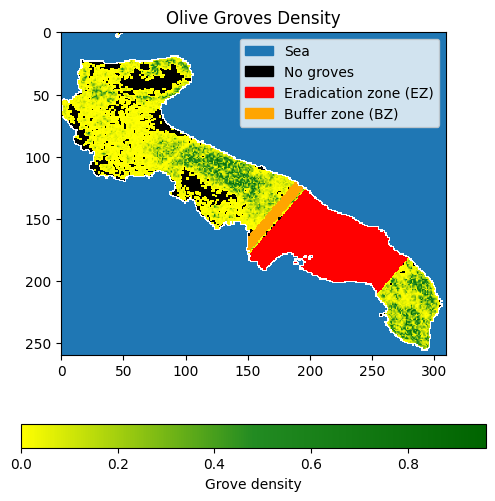

In [11]:
# CREATE OLIVE GROVE DENSITY, FROM FILE OR RANDOMLY GENERATED

if FROM_FILE:
    file_path = "olivegrowthprop.mat"
    mat = sp.io.loadmat(file_path)
    GRID = Grid(density=mat["olivegrowthprop"], control=CONTROL, EZW=EZW, BZW=BZW)

else:
    GRID = Grid(shape=(ROWS, COLS))

# PLOT DISTRIBUTION OF OLIVE GROVES
GRID.plot_density(figsize=(6,6))

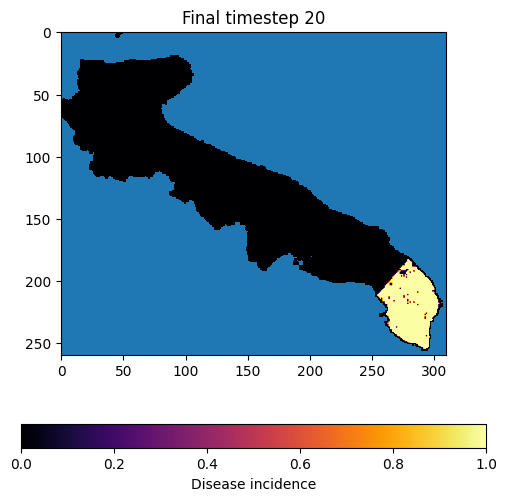

In [12]:
# RUN SIMULATION AND PLOT OUTCOME

np.random.seed(5)

timesteps = 20

GRID.simulate(timesteps, parameters)
# GRID.plot_incidence(figsize=(6,6))
GRID.plot_final_incidence(figsize=(6,6))

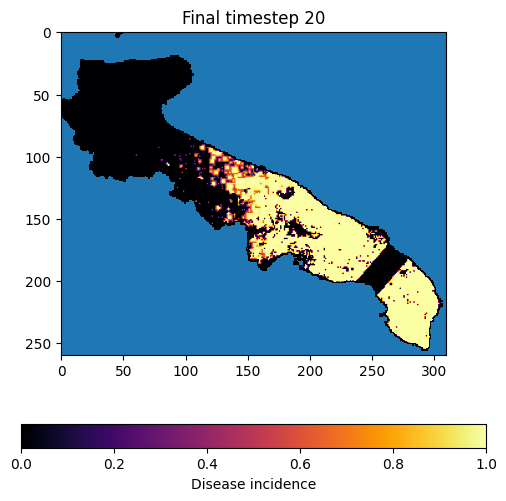

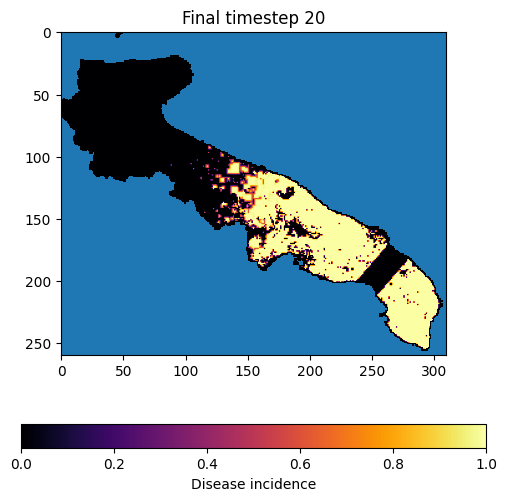

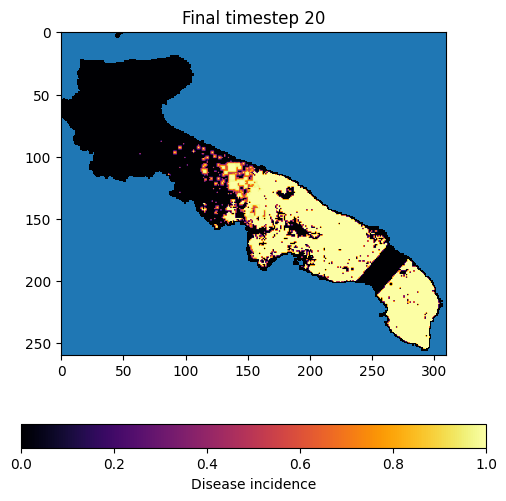

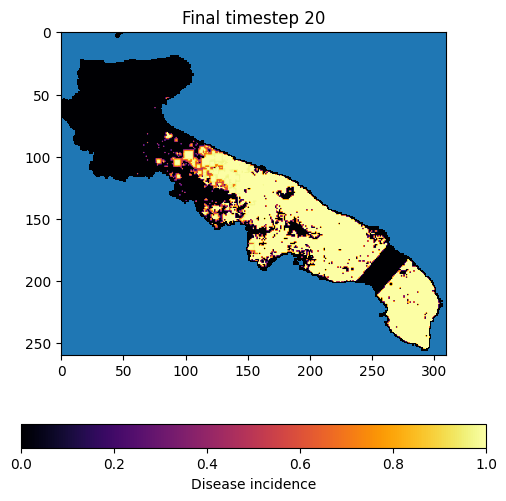

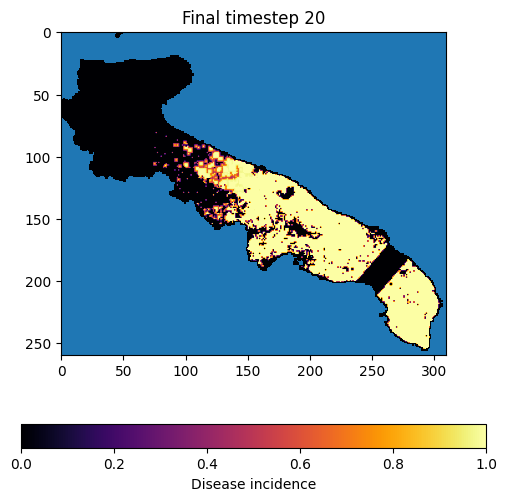

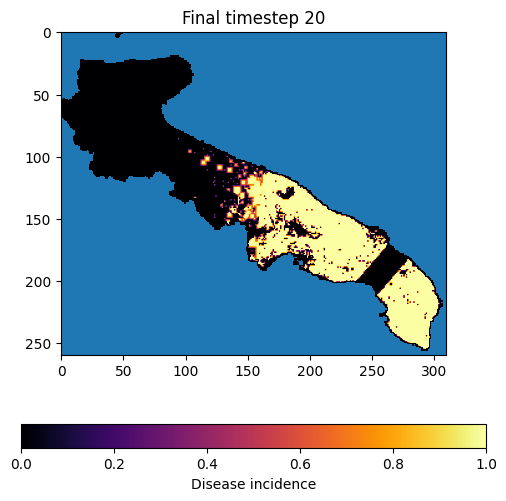

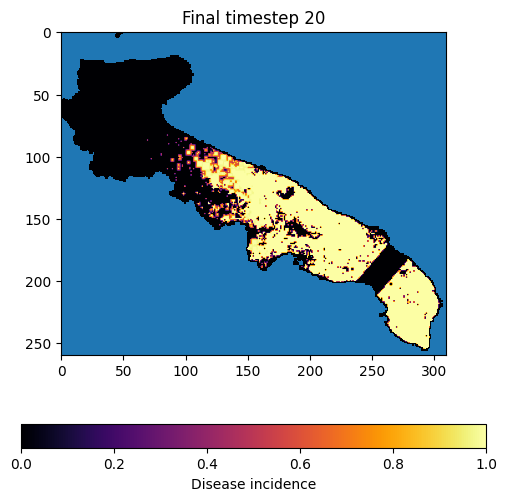

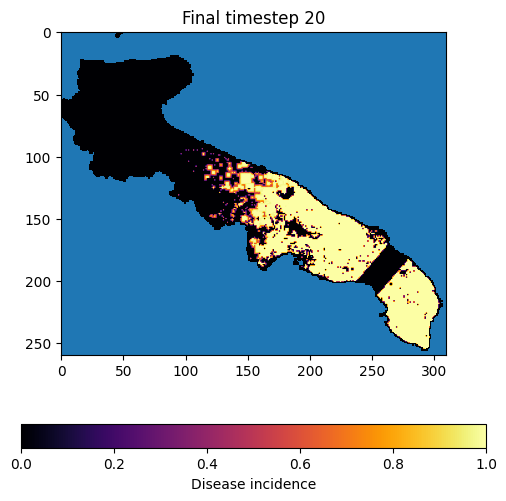

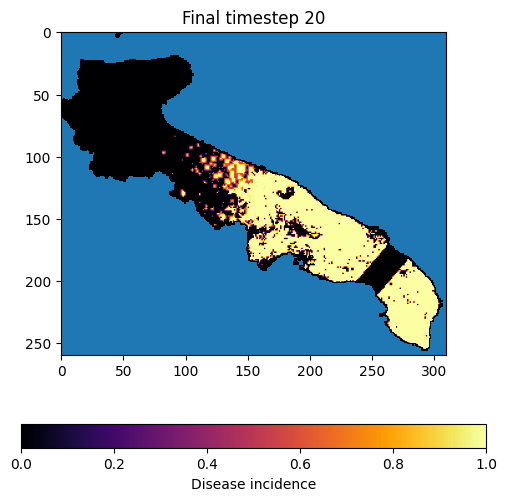

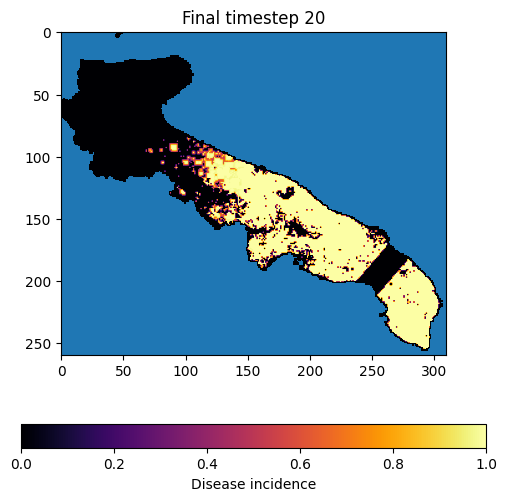

In [47]:
# # EVALUATE RISK

# N = 10
# final_incidence = np.zeros((N, GRID.rows, GRID.cols))

# for i in range(N):
#     GRID.simulate(timesteps, parameters, dispersal_type=dispersal_type)
#     final_incidence[i] = GRID.output[GRID.timesteps]
#     GRID.plot_final_incidence(figsize=(6,6))

In [48]:
# # PLOT RISK

# risk = np.mean(final_incidence, axis=0)
# im_sea = np.ma.array(GRID.density, mask=~GRID.sea_mask)

# fig, ax = plt.subplots(figsize=(6,6))
# im = ax.imshow(risk, cmap="inferno", interpolation=None, norm=colors.Normalize(vmin=0, vmax=1))
# ax.imshow(im_sea, cmap=colors.ListedColormap(['tab:blue']), interpolation=None)
# ax.set_title("5-year risk")
# cbar = fig.colorbar(im, ax=ax, orientation="horizontal")
# cbar.set_label("Risk")

# plt.show()

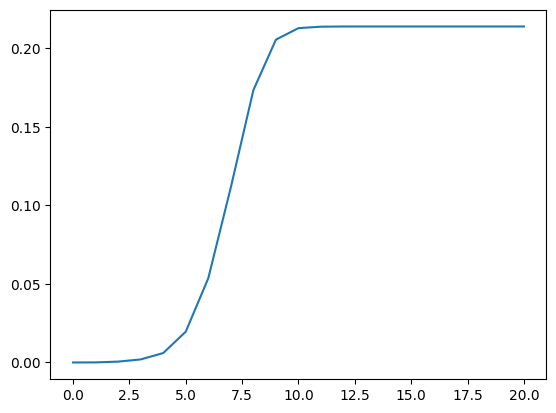

In [13]:
# EVALUATE AVERAGE INCIDENCE OVER GRID TIMESERIES
# Short_long kernel with and without Control Zone

average = np.zeros(GRID.output.shape[0])

for t in range(GRID.output.shape[0]):
    average[t] = GRID.output[t][GRID.grove_mask].mean()

plt.plot(np.arange(GRID.output.shape[0]), average)

plt.show()

In [ ]:
# INCLUDE VECTOR POPULATION DYNAMICS

In [ ]:
# EVALUATE SPEED OF EPIDEMIC SPREAD 

# Get the centroid of each grid cell. 
# Create distance classes:
# - 1 km radius around centroid of seed cell (includes all cells whose centroid is within the radius)
# - 1 km wide concentric rings around centroid of seed cell (same) 

In [ ]:
# add "scale" parameter for rescaling of random samples; resolved by simply modifying alpha exponent parameter
